In [2]:
import micom
import micom.measures
import pandas as pd
import numpy as np 
import scipy.stats
from matplotlib.patches import Rectangle

import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *

%matplotlib inline

## Gather Arivale Metagenomes from GGH Study
122 samples originally from Arivale

In [31]:
ggh_data = pd.read_csv('/proj/gibbons/2023_arivale_ggh/data/S_counts.csv')
ggh_data = ggh_data[['sample_id', 'new_est_reads', 'lineage']]
ggh_data['species'] = ggh_data['lineage'].str.split(';').str[6].str.split('__').str[1]
ggh_data.drop(columns = 'lineage', inplace = True)
ggh_data.rename(columns = {'new_est_reads':'reads'}, inplace = True)
ggh_data['id'] = ggh_data['species'].str.replace(' ', '_')
ggh_data['sample_id'] = ggh_data['sample_id'].str.lstrip('S_').astype('str')
ggh_data['sample'] = ggh_data['sample_id']
ggh_data['sample'].nunique()

122

## Gather Arivale Metagenomes
40 Samples from Arivale 

In [32]:
metadata = pd.read_csv('/proj/arivale/microbiome/shotgun_metagenomics/2018_arivale/manifest.csv',
                       index_col = 0)
metadata['index'] = metadata['forward'].str.replace('_R1_001.fastq.gz$', '', regex=True)
metadata.set_index('index', inplace = True)
metadata = metadata.drop_duplicates(subset = 'vendor_observation_id', keep = 'first')


arivale_data = pd.read_csv('/proj/arivale/microbiome/shotgun_metagenomics/2018_arivale/S_counts.csv')
arivale_data = arivale_data.loc[arivale_data['sample'].isin(metadata.index)]
arivale_data['sample_id'] = arivale_data['sample'].map(metadata['vendor_observation_id'].to_dict()).astype('str')
arivale_data = arivale_data[['species','reads','sample_id', 'sample']]
arivale_data = arivale_data.groupby(by = ['sample_id','species','sample'])['reads'].agg('sum').reset_index()
arivale_data['id'] = arivale_data['species']
arivale_data['species'] = arivale_data['species'].str.replace('_',' ')
arivale_data['sample'].nunique()

40

# Merge Taxonomy Tables
Merge the tables into one for MICOM

In [56]:
taxonomy = pd.concat([arivale_data, ggh_data])a
taxonomy['abundance'] = taxonomy['reads']/taxonomy.groupby('sample_id')['reads'].transform('sum')
taxonomy = taxonomy.groupby(['sample_id','species', 'id','sample']).sum().reset_index()
taxonomy.groupby('sample_id')['sample'].nunique().sort_values().tail(8)

sample_id
22001612561205    1
22001612561270    1
22001701511216    2
22001612560574    2
22001612560784    2
22001701510027    2
22001612561863    2
22001612562289    2
Name: sample, dtype: int64

In [62]:
taxonomy[taxonomy['sample_id'] == '22001612562289']['sample'].unique()

array(['B22001612562289-T22001612562289_S13_L001', '22001612562289'],
      dtype=object)

In [7]:
def add_all_probiotic(taxonomy):
    taxonomy_probiotic_total = pd.DataFrame()
    for sample in taxonomy['sample_id'].unique():
        taxonomy_reduced = taxonomy[taxonomy['sample_id'] == sample].copy()
        taxonomy_reduced['abundance'] = taxonomy_reduced['abundance']*0.95
        taxonomy_probiotic = pd.concat([taxonomy_reduced,pd.DataFrame({
                  'sample_id':[sample, sample, sample, sample, sample], 
                  'species': ['Akkermansia muciniphila','Clostridium beijerinckii',
                              'Clostridium butyricum','Bifidobacterium longum',
                              'Anaerobutyricum hallii'],
                  'abundance':[0.01, 0.01, 0.01, 0.01, 0.01], 
                  'id':['Akkermansia_muciniphila','Clostridium_beijerinckii',
                              'Clostridium_butyricum','Bifidobacterium_longum',
                              'Anaerobutyricum_hallii']})])
        taxonomy_probiotic_total = pd.concat([taxonomy_probiotic_total, taxonomy_probiotic])

    return taxonomy_probiotic_total

taxonomy_probiotic = add_all_probiotic(taxonomy)
taxonomy_probiotic = taxonomy_probiotic.groupby(['sample_id','id','species']).sum().reset_index()

In [9]:
agora_augmented = '/proj/gibbons/nbohmann/agora103_augmented.qza'

manifest = micom.workflows.build(taxonomy_probiotic,
                                 model_db=agora_augmented, 
                                 out_folder='../Arivale_mixedAMUC_5%_001',
                                 cutoff=0.001, 
                                 threads=10)

Output()

[05/02/25 03:13:47] WARNING  Less than 50% of the abundance     ]8;id=446166;file:///users/nbohmann/miniconda3/envs/micom-host/lib/python3.9/site-packages/micom/community.py\community.py]8;;\:]8;id=880699;file:///users/nbohmann/miniconda3/envs/micom-host/lib/python3.9/site-packages/micom/community.py#233\233]8;;\
                             could be matched to the model                      
                             database. Model `22001612560096`                   
                             may not be representative of the                   
                             sample                                             
[05/02/25 03:13:47] WARNING  Less than 50% of the abundance     ]8;id=829365;file:///users/nbohmann/miniconda3/envs/micom-host/lib/python3.9/site-packages/micom/community.py\community.py]8;;\:]8;id=805111;file:///users/nbohmann/miniconda3/envs/micom-host/lib/python3.9/site-packages/micom/community.py#233\233]8;;\
                             c

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



[05/02/25 04:56:55] WARNING  Less than 50% of the abundance     ]8;id=685067;file:///users/nbohmann/miniconda3/envs/micom-host/lib/python3.9/site-packages/micom/community.py\community.py]8;;\:]8;id=977070;file:///users/nbohmann/miniconda3/envs/micom-host/lib/python3.9/site-packages/micom/community.py#233\233]8;;\
                             could be matched to the model                      
                             database. Model `22001612562632`                   
                             may not be representative of the                   
                             sample                                             


In [3]:
eu_medium = micom.qiime_formats.load_qiime_medium('/proj/gibbons/refs/micom_media/media/average_european_agora2.qza')
eu_medium_inulin = eu_medium.copy()
eu_medium_pectin = eu_medium.copy()
eu_medium_malto = eu_medium.copy()
eu_medium_starch = eu_medium.copy()
eu_medium_hemp = eu_medium.copy()
eu_medium_psyllium= eu_medium.copy()

eu_medium_inulin.loc['EX_inulin_m', 'flux'] = 6.14
eu_medium_pectin.loc['EX_pect_m', 'flux'] = 0.4
eu_medium_starch.loc['EX_strch1_m', 'flux'] = 16.65
eu_medium_malto.loc['EX_dextrin_m', 'flux'] = 30.28
eu_medium_hemp.loc['EX_cellul_m', 'flux'] = 0.37
eu_medium_psyllium.loc['EX_arabinoxyl_m', 'flux'] = 4.09

hf_medium = micom.qiime_formats.load_qiime_medium('/proj/gibbons/refs/micom_media/media/vmh_high_fiber_agora.qza')


In [4]:
manifest = pd.read_csv('../Arivale_mixedAMUC_5%_001/manifest.csv')
growth_baseline = micom.workflows.grow(manifest, 
                                  model_folder = '../Arivale_mixedAMUC_5%_001/',
                                  medium = eu_medium,
                                  tradeoff = 0.99, 
                                  strategy = 'none',                                    
                                  threads = 20)
growth_inulin = micom.workflows.grow(manifest, 
                                  model_folder = '../Arivale_mixedAMUC_5%_001/',
                                  medium = eu_medium_inulin,
                                  tradeoff = 0.99, 
                                  strategy = 'none',                                    
                                  threads = 20)
growth_pect = micom.workflows.grow(manifest, 
                                  model_folder = '../Arivale_mixedAMUC_5%_001/',
                                  medium = eu_medium_pectin,
                                  tradeoff = 0.99, 
                                  strategy = 'none',                                    
                                  threads = 20)
growth_starch = micom.workflows.grow(manifest, 
                                  model_folder = '../Arivale_mixedAMUC_5%_001/',
                                  medium = eu_medium_starch,
                                  tradeoff = 0.99, 
                                  strategy = 'none',                                    
                                  threads = 20)
growth_malto = micom.workflows.grow(manifest, 
                                  model_folder = '../Arivale_mixedAMUC_5%_001/',
                                  medium = eu_medium_malto,
                                  tradeoff = 0.99, 
                                  strategy = 'none',                                    
                                  threads = 20)
growth_hemp = micom.workflows.grow(manifest, 
                                  model_folder = '../Arivale_mixedAMUC_5%_001/',
                                  medium = eu_medium_hemp,
                                  tradeoff = 0.99, 
                                  strategy = 'none',                                    
                                  threads = 20)
growth_psyllium = micom.workflows.grow(manifest, 
                                  model_folder = '../Arivale_mixedAMUC_5%_001/',
                                  medium = eu_medium_psyllium,
                                  tradeoff = 0.99, 
                                  strategy = 'none',                                    
                                  threads = 20)
growth_hf = micom.workflows.grow(manifest, 
                                  model_folder = '../Arivale_mixedAMUC_5%_001/',
                                  medium = hf_medium,
                                  tradeoff = 0.99, 
                                  strategy = 'none',                                    
                                  threads = 20)


manifest = pd.read_csv('../Arivale_mixedAMUC_noPro_001/manifest.csv')
control_baseline = micom.workflows.grow(manifest, 
                                  model_folder = '../Arivale_mixedAMUC_noPro_001/',
                                  medium = eu_medium,
                                  tradeoff = 0.99, 
                                  strategy = 'none',                                    
                                  threads = 20)
control_inulin = micom.workflows.grow(manifest, 
                                  model_folder = '../Arivale_mixedAMUC_noPro_001/',
                                  medium = eu_medium_inulin,
                                  tradeoff = 0.99, 
                                  strategy = 'none',                                    
                                  threads = 20)
control_pect = micom.workflows.grow(manifest, 
                                  model_folder = '../Arivale_mixedAMUC_noPro_001/',
                                  medium = eu_medium_pectin,
                                  tradeoff = 0.99, 
                                  strategy = 'none',                                    
                                  threads = 20)
control_starch = micom.workflows.grow(manifest, 
                                  model_folder = '../Arivale_mixedAMUC_noPro_001/',
                                  medium = eu_medium_starch,
                                  tradeoff = 0.99, 
                                  strategy = 'none',                                    
                                  threads = 20)
control_malto = micom.workflows.grow(manifest, 
                                  model_folder = '../Arivale_mixedAMUC_noPro_001/',
                                  medium = eu_medium_malto,
                                  tradeoff = 0.99, 
                                  strategy = 'none',                                    
                                  threads = 20)
control_hemp = micom.workflows.grow(manifest, 
                                  model_folder = '../Arivale_mixedAMUC_noPro_001/',
                                  medium = eu_medium_hemp,
                                  tradeoff = 0.99, 
                                  strategy = 'none',                                    
                                  threads = 20)
control_psyllium = micom.workflows.grow(manifest, 
                                  model_folder = '../Arivale_mixedAMUC_noPro_001/',
                                  medium = eu_medium_psyllium,
                                  tradeoff = 0.99, 
                                  strategy = 'none',                                    
                                  threads = 20)
control_hf = micom.workflows.grow(manifest, 
                                  model_folder = '../Arivale_mixedAMUC_noPro_001/',
                                  medium = hf_medium,
                                  tradeoff = 0.99, 
                                  strategy = 'none',                                    
                                  threads = 20)

Output()

Output()

Output()

Output()

Output()

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [75]:
# # Gather growth rates
# rates_baseline = growth_baseline.growth_rates
# rates_baseline['treatment'] = 'No Prebiotic'
# rates_baseline['probiotic'] = '+'
# rates_inulin = growth_inulin.growth_rates
# rates_inulin['treatment'] = 'Inulin'
# rates_inulin['probiotic'] = '+'
# rates_pect = growth_pect.growth_rates
# rates_pect['treatment'] = 'Pectin'
# rates_pect['probiotic'] = '+'
# rates_starch = growth_starch.growth_rates
# rates_starch['treatment'] = 'Starch'
# rates_starch['probiotic'] = '+'
# rates_malto = growth_malto.growth_rates
# rates_malto['treatment'] = 'Maltodextrin'
# rates_malto['probiotic'] = '+'
# rates_hemp = growth_hemp.growth_rates
# rates_hemp['treatment'] = 'Hemp Seed'
# rates_hemp['probiotic'] = '+'
# rates_psyllium = growth_psyllium.growth_rates
# rates_psyllium['treatment'] = 'Psyllium Husk'
# rates_psyllium['probiotic'] = '+'
# rates_hf = growth_hf.growth_rates
# rates_hf['treatment'] = 'High Fiber'
# rates_hf['probiotic'] = '+'

# control_rates_baseline = control_baseline.growth_rates
# control_rates_baseline['treatment'] = 'No Prebiotic'
# control_rates_baseline['probiotic'] = '-'
# control_rates_inulin = control_inulin.growth_rates
# control_rates_inulin['treatment'] = 'Inulin'
# control_rates_inulin['probiotic'] = '-'
# control_rates_pect = control_pect.growth_rates
# control_rates_pect['treatment'] = 'Pectin'
# control_rates_pect['probiotic'] = '-'
# control_rates_starch = control_starch.growth_rates
# control_rates_starch['treatment'] = 'Starch'
# control_rates_starch['probiotic'] = '-'
# control_rates_malto = control_malto.growth_rates
# control_rates_malto['treatment'] = 'Maltodextrin'
# control_rates_malto['probiotic'] = '-'
# control_rates_hemp = control_hemp.growth_rates
# control_rates_hemp['treatment'] = 'Hemp Seed'
# control_rates_hemp['probiotic'] = '-'
# control_rates_psyllium = control_psyllium.growth_rates
# control_rates_psyllium['treatment'] = 'Psyllium Husk'
# control_rates_psyllium['probiotic'] = '-'
# control_rates_hf = control_hf.growth_rates
# control_rates_hf['treatment'] = 'High Fiber'
# control_rates_hf['probiotic'] = '-'


# rates_probiotic = pd.concat([rates_baseline, rates_inulin, rates_pect, rates_starch, rates_malto, rates_hemp, rates_psyllium, rates_hf,
#                             control_rates_baseline, control_rates_inulin, control_rates_pect, control_rates_starch, control_rates_malto,control_rates_hemp,control_rates_psyllium,
#                              control_rates_hf])

# rates_probiotic.to_csv('/proj/gibbons/2024_Pendulum_trial/arivale_probiotic_rates.csv')

rates_probiotic = pd.read_csv('/proj/gibbons/2024_Pendulum_trial/arivale_probiotic_rates.csv', index_col = 0)

# Isolate Probiotics
rates_probiotic = rates_probiotic[rates_probiotic.index.isin(['Akkermansia_muciniphila',
                                                              'Clostridium_beijerinckii',
                                                              'Clostridium_butyricum',
                                                              'Bifidobacterium_longum',
                                                              'Anaerobutyricum_hallii',
                                                              ])].reset_index()

rates_probiotic.compartments = rates_probiotic.compartments.str.replace('Akkermansia_muciniphila','AMUC').str.replace(
                                                          'Clostridium_beijerinckii','CBEI').str.replace(
                                                          'Clostridium_butyricum','CBUT').str.replace(
                                                          'Bifidobacterium_longum','BINF').str.replace(
                                                          'Anaerobutyricum_hallii', 'AHAL')
rates_probiotic['sample_id'] = rates_probiotic['sample_id'].astype('str')+'_'+rates_probiotic['treatment']+'_'+rates_probiotic['probiotic']

# # Log scale growth rates
rates_probiotic['growth_rate_scaled'] = np.log10(rates_probiotic[['growth_rate']]+0.00000001)

# Threshold log-scaled growth rates
rates_probiotic.loc[rates_probiotic['growth_rate_scaled']>=-3, 'MCMM_engraftment'] = 1
rates_probiotic['MCMM_engraftment'].fillna(0.0, inplace = True)

rates_probiotic_pvt = pd.pivot_table(rates_probiotic, 
                    index='compartments',
                    columns='sample_id',
                    values='MCMM_engraftment').fillna(0.0)
rates_probiotic_pvt = rates_probiotic_pvt.T
rates_probiotic_pvt['treatment'] = rates_probiotic_pvt.index.str.split('_').str[1]
rates_probiotic_pvt['probiotic'] = rates_probiotic_pvt.index.str.split('_').str[2]
rates_probiotic_pvt = rates_probiotic_pvt.sort_values(by = 'treatment')
custom_order = ['No Prebiotic','Inulin','Pectin','Starch','Maltodextrin','Hemp Seed','Psyllium Husk','High Fiber']
rates_probiotic_pvt[rates_probiotic_pvt['treatment'] =='No Prebiotic']

palette = sns.color_palette("Set2", 8)
sns.set(font_scale=3)

lut = dict(zip(rates_probiotic_pvt['treatment'].unique(),palette))
row_colors = rates_probiotic_pvt['treatment'].map(lut)

rates_probiotic_pvt['treatment'] = pd.Categorical(rates_probiotic_pvt['treatment'], categories=custom_order, ordered=True)
rates_probiotic_pvt = rates_probiotic_pvt.sort_values('treatment')

/tmp/ipykernel_2286665/2455175945.py:81: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




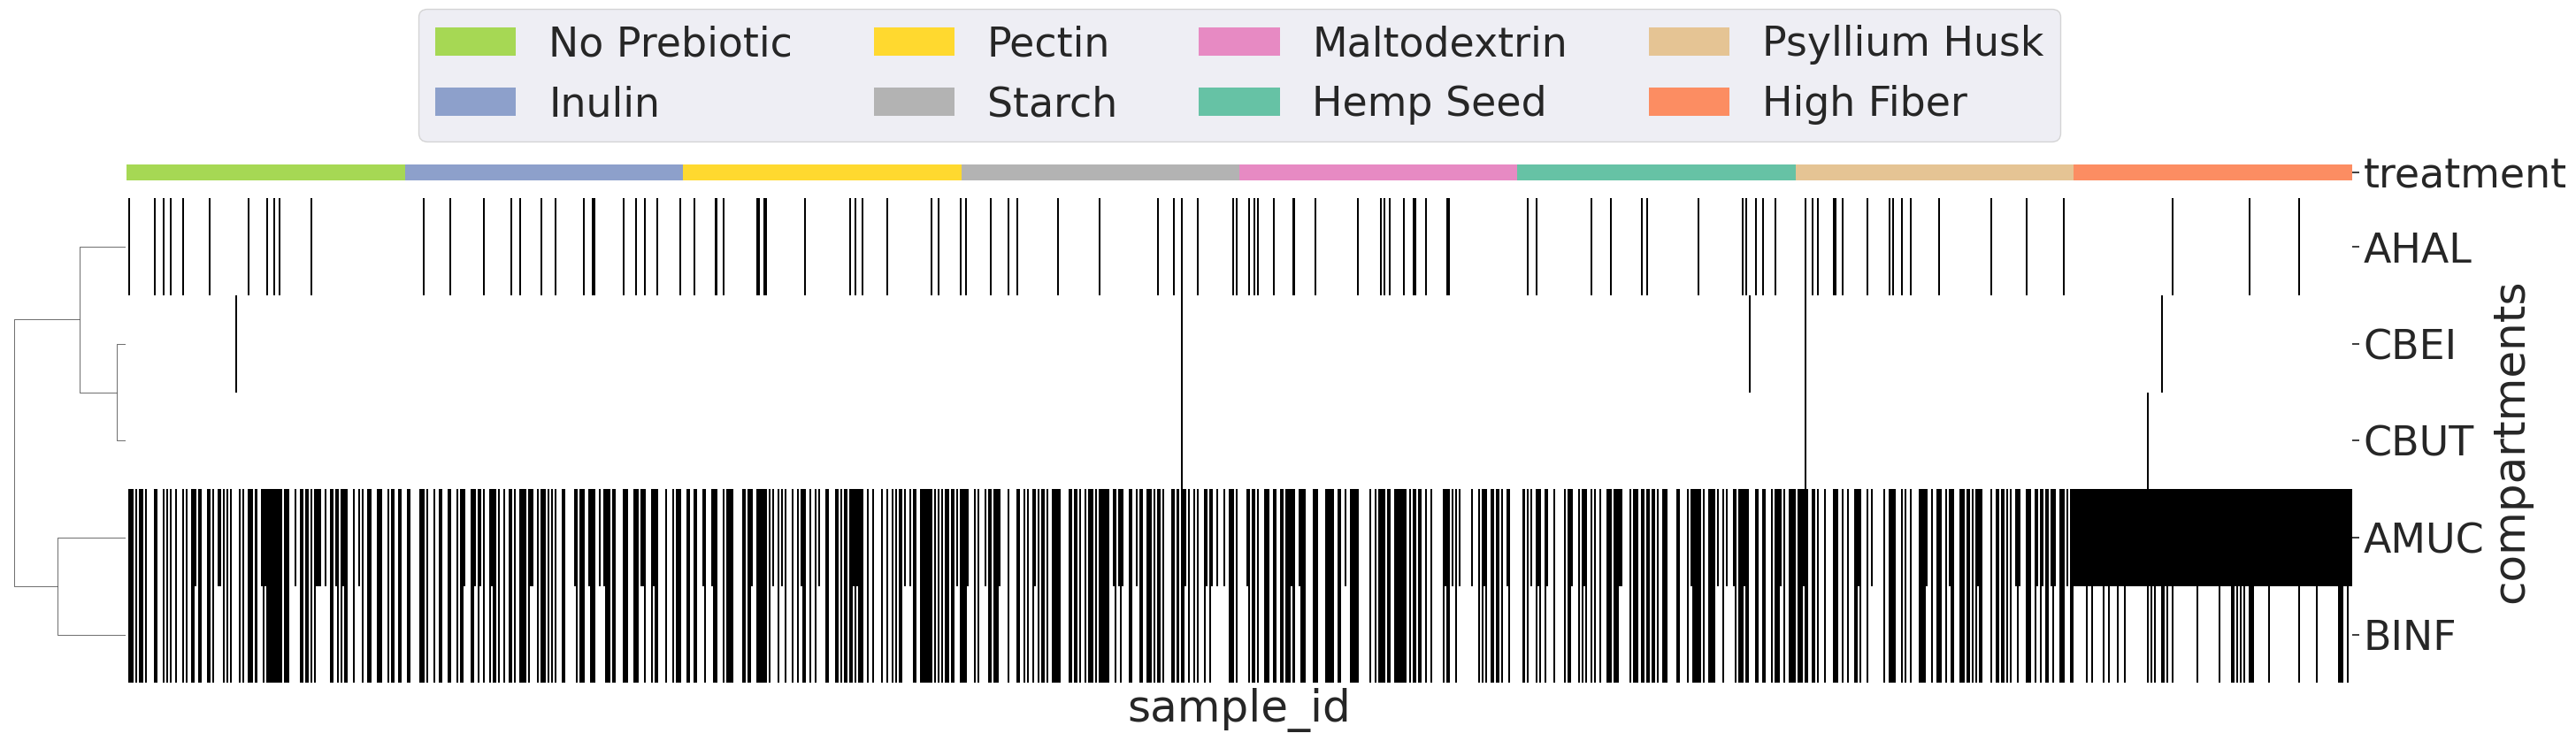

In [78]:


x = sns.clustermap(rates_probiotic_pvt[rates_probiotic_pvt['probiotic'] == '+'].iloc[:,:-2].T, yticklabels=True, 
                   col_colors = row_colors, col_cluster = False, xticklabels=False,  cmap='gray_r',cbar_pos=None,   # <- This removes the color bar
                   figsize=(30, 8), dendrogram_ratio=0.05)

for label in rates_probiotic_pvt['treatment'].unique():
    x.ax_col_dendrogram.bar(0, 0, color=lut[label],
                            label=label, linewidth=0)
x.ax_col_dendrogram.legend(loc='upper center', bbox_to_anchor=(0.5, 6), ncol=4)
x.savefig('../figures/arivale_heatmap.svg', dpi=200)


In [55]:
# production_baseline = micom.measures.production_rates(growth_baseline)
# production_baseline['treatment'] = 'No Prebiotic'
# production_baseline['probiotic'] = '+'

# production_inulin = micom.measures.production_rates(growth_inulin)
# production_inulin['treatment'] = 'Inulin'
# production_inulin['probiotic'] = '+'

# production_pect = micom.measures.production_rates(growth_pect)
# production_pect['treatment'] = 'Pectin'
# production_pect['probiotic'] = '+'

# production_starch = micom.measures.production_rates(growth_starch)
# production_starch['treatment'] = 'Starch'
# production_starch['probiotic'] = '+'

# production_malto = micom.measures.production_rates(growth_malto)
# production_malto['treatment'] = 'Maltodextrin'
# production_malto['probiotic'] = '+'

# production_hemp = micom.measures.production_rates(growth_hemp)
# production_hemp['treatment'] = 'Hemp Seed'
# production_hemp['probiotic'] = '+'

# production_psyllium = micom.measures.production_rates(growth_psyllium)
# production_psyllium['treatment'] = 'Psyllium Husk'
# production_psyllium['probiotic'] = '+'

# production_hf = micom.measures.production_rates(growth_hf)
# production_hf['treatment'] = 'High Fiber'
# production_hf['probiotic'] = '+'


# control_production_baseline = micom.measures.production_rates(control_baseline)
# control_production_baseline['treatment'] = 'No Prebiotic'
# control_production_baseline['probiotic'] = '-'

# control_production_inulin = micom.measures.production_rates(control_inulin)
# control_production_inulin['treatment'] = 'Inulin'
# control_production_inulin['probiotic'] = '-'

# control_production_pect = micom.measures.production_rates(control_pect)
# control_production_pect['treatment'] = 'Pectin'
# control_production_pect['probiotic'] = '-'

# control_production_starch = micom.measures.production_rates(control_starch)
# control_production_starch['treatment'] = 'Starch'
# control_production_starch['probiotic'] = '-'

# control_production_malto = micom.measures.production_rates(control_malto)
# control_production_malto['treatment'] = 'Maltodextrin'
# control_production_malto['probiotic'] = '-'

# control_production_hemp = micom.measures.production_rates(control_hemp)
# control_production_hemp['treatment'] = 'Hemp Seed'
# control_production_hemp['probiotic'] = '-'

# control_production_psyllium = micom.measures.production_rates(control_psyllium)
# control_production_psyllium['treatment'] = 'Psyllium Husk'
# control_production_psyllium['probiotic'] = '-'


# control_production_hf = micom.measures.production_rates(control_hf)
# control_production_hf['treatment'] = 'High Fiber'
# control_production_hf['probiotic'] = '-'


# production = pd.concat([production_baseline, production_inulin, production_pect, production_starch, production_malto, production_hemp, production_psyllium, production_hf,
#                        control_production_baseline, control_production_inulin, control_production_pect, control_production_starch, control_production_malto,
#                         control_production_hemp, control_production_psyllium, control_production_hf])

# production.to_csv('/proj/gibbons/2024_Pendulum_trial/arivale_metabolic_production.csv')
production = pd.read_csv('/proj/gibbons/2024_Pendulum_trial/arivale_metabolic_production.csv')

/tmp/ipykernel_2286665/1066633729.py:73: DtypeWarning: Columns (8,9,14,15,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.


In [56]:
production_but = production[production['metabolite'] == 'but[e]'] # Isolate SCFAs
production_ppa = production[production['metabolite'] == 'ppa[e]']
production_but

,Unnamed: 0,sample_id,metabolite,flux,name,molecular_weight,C_number,N_number,bigg.metabolite,biocyc,...,lipidmaps,metanetx.chemical,pubchem.compound,reactome,sbo,seed.compound,smiles,reaction,treatment,probiotic
57,57,22001612560041,but[e],6.194538,butyrate,87.09718,4,0,NaN,NaN,...,NaN,NaN,264.0,NaN,NaN,NaN,NaN,EX_but(e),No Prebiotic,+
630,630,22001612560086,but[e],6.068410,butyrate,87.09718,4,0,NaN,NaN,...,NaN,NaN,264.0,NaN,NaN,NaN,NaN,EX_but(e),No Prebiotic,+
856,856,22001612560096,but[e],2.878135,butyrate,87.09718,4,0,NaN,NaN,...,NaN,NaN,264.0,NaN,NaN,NaN,NaN,EX_but(e),No Prebiotic,+
1005,1005,22001612560121,but[e],2.444935,butyrate,87.09718,4,0,NaN,NaN,...,NaN,NaN,264.0,NaN,NaN,NaN,NaN,EX_but(e),No Prebiotic,+
1169,1169,22001612560133,but[e],5.176304,butyrate,87.09718,4,0,NaN,NaN,...,NaN,NaN,264.0,NaN,NaN,NaN,NaN,EX_but(e),No Prebiotic,+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465205,27527,22001701511736,but[e],32.939857,butyrate,87.09718,4,0,NaN,NaN,...,NaN,NaN,264.0,NaN,NaN,NaN,NaN,EX_but(e),High Fiber,-
465404,27726,22001701511741,but[e],29.073514,butyrate,87.09718,4,0,NaN,NaN,...,NaN,NaN,264.0,NaN,NaN,NaN,NaN,EX_but(e),High Fiber,-
465597,27919,22001701511930,but[e],32.973771,butyrate,87.09718,4,0,NaN,NaN,...,NaN,NaN,264.0,NaN,NaN,NaN,NaN,EX_but(e),High Fiber,-
465782,28104,22001701511986,but[e],12.468956,butyrate,87.09718,4,0,NaN,NaN,...,NaN,NaN,264.0,NaN,NaN,NaN,NaN,EX_but(e),High Fiber,-


/users/nbohmann/miniconda3/envs/micom-host/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 8 x 8 in image.
/users/nbohmann/miniconda3/envs/micom-host/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/arivale_butyrate.svg


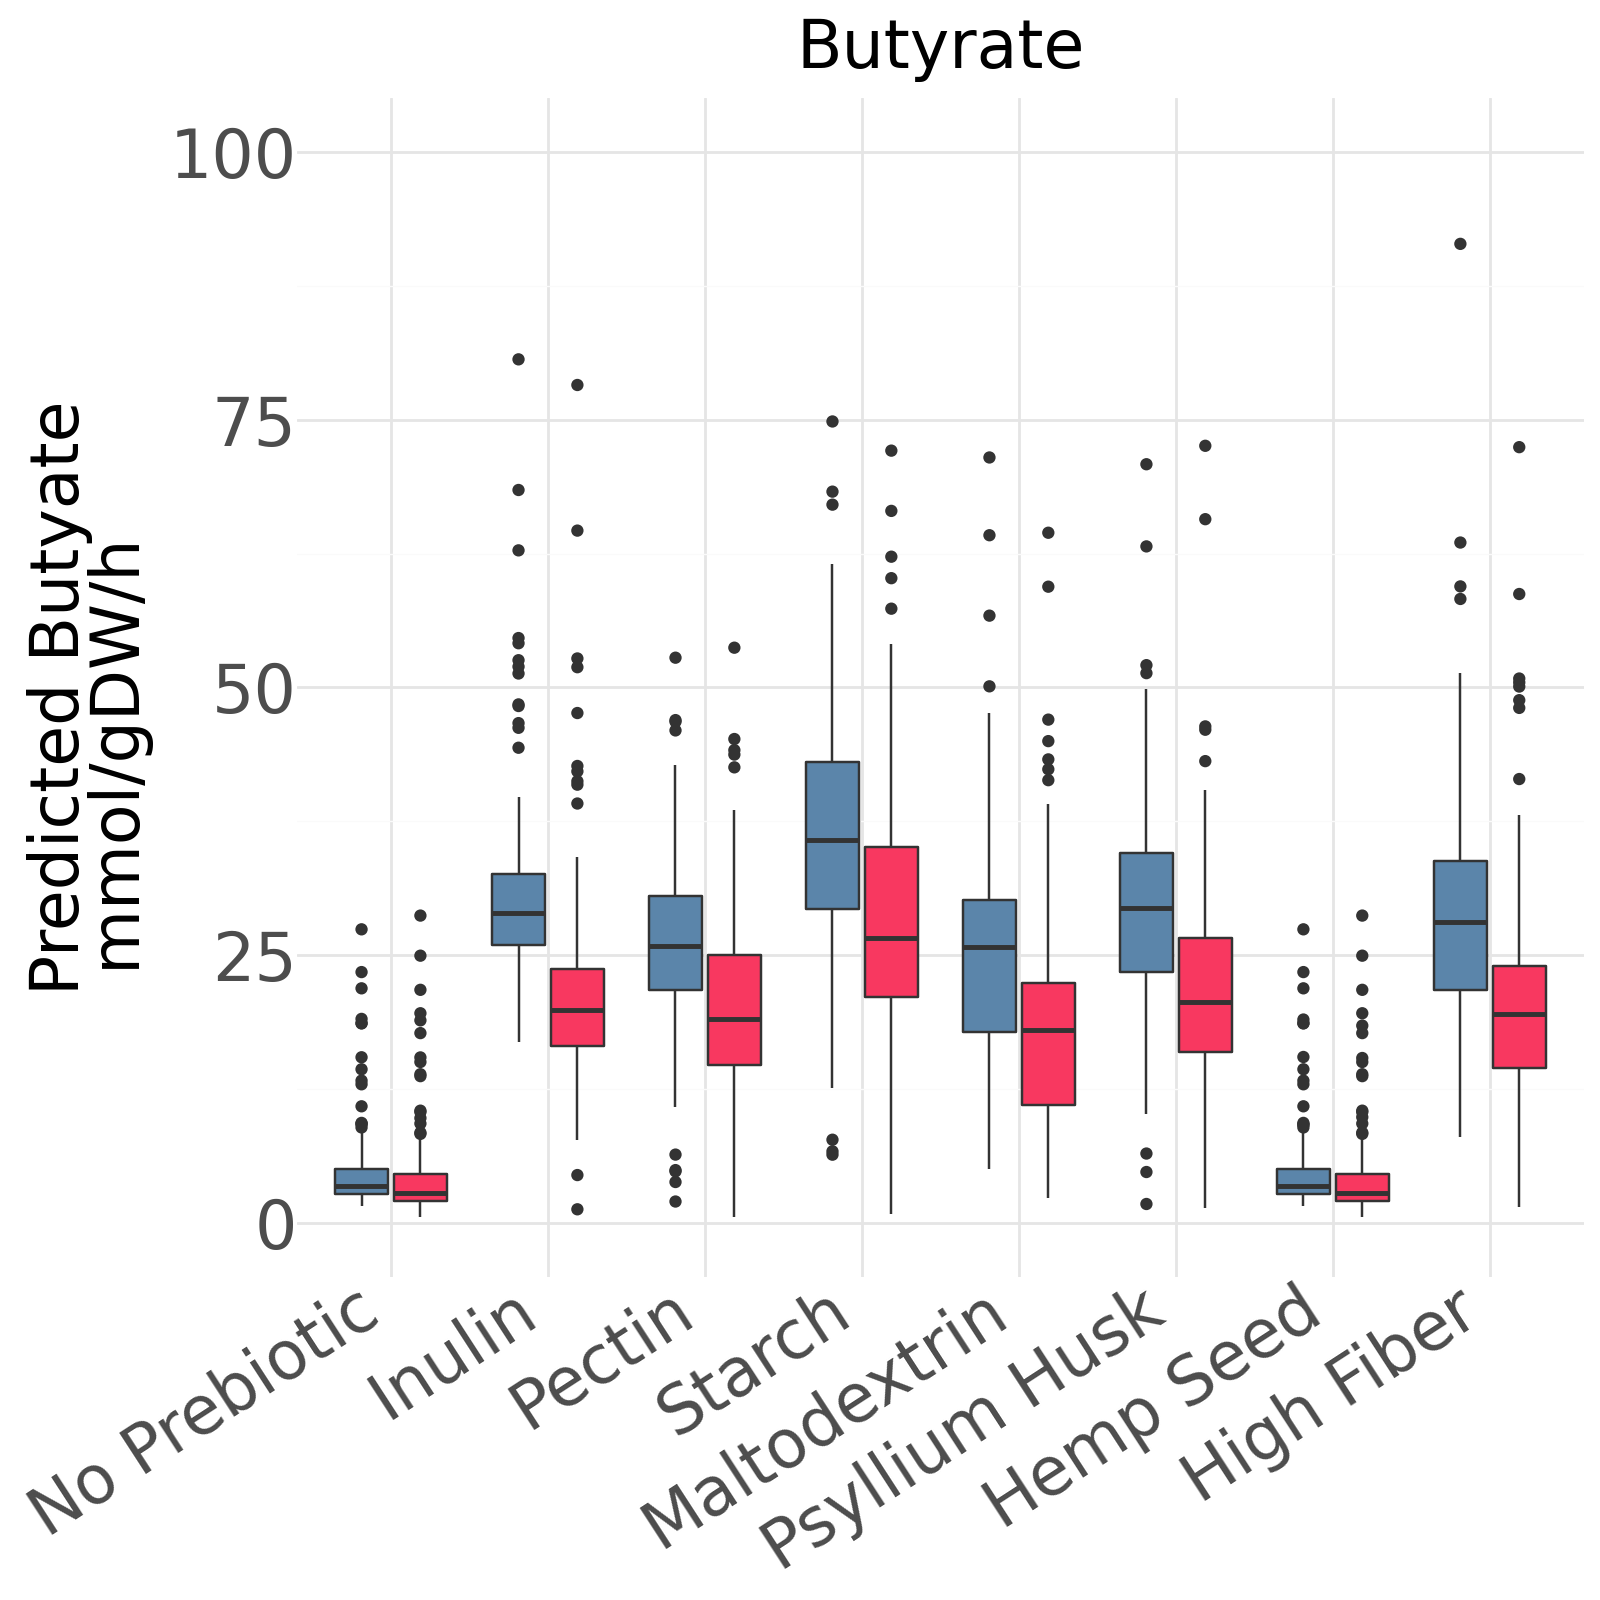

In [68]:
arivale_butyrate = (ggplot(production_but, aes(x = 'treatment', y = 'flux'))
                    +geom_boxplot(aes(fill = 'probiotic'))
                    +scale_fill_manual(values = {'+': '#5B85AA',
                                                 '-': '#F83860'
                                                })
                    +scale_x_discrete(limits = ['No Prebiotic', 'Inulin','Pectin','Starch','Maltodextrin','Psyllium Husk','Hemp Seed','High Fiber'])
                    +labs(y = 'Predicted Butyate \n mmol/gDW/h', x = '',title = 'Butyrate', fill = 'Probiotic Treatment')
                    +theme_minimal()    
                    +ylim(0, 100)
                    +theme(figure_size=(8, 8),legend_position='none', text=element_text(size=24),axis_text_x=element_text(rotation=33, hjust=1))
                   )


ggsave(arivale_butyrate, '../figures/arivale_butyrate.svg', dpi = 300)

arivale_butyrate

In [486]:
scipy.stats.shapiro(production_but[(production_but['treatment'] == 'Inulin')&(production_but['probiotic']== '-')]['flux'])

ShapiroResult(statistic=0.708228896532664, pvalue=3.136935356342844e-16)

In [95]:
scipy.stats.mannwhitneyu(production_but[(production_but['treatment'] == 'No Prebiotic')&(production_but['probiotic']== '+')]['flux'],
production_but[(production_but['treatment'] == 'No Prebiotic')&(production_but['probiotic']== '-')]['flux'])

MannwhitneyuResult(statistic=14913.0, pvalue=0.0005715981476875245)

/users/nbohmann/miniconda3/envs/micom-host/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 12 x 8 in image.
/users/nbohmann/miniconda3/envs/micom-host/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/arivale_propionate.svg


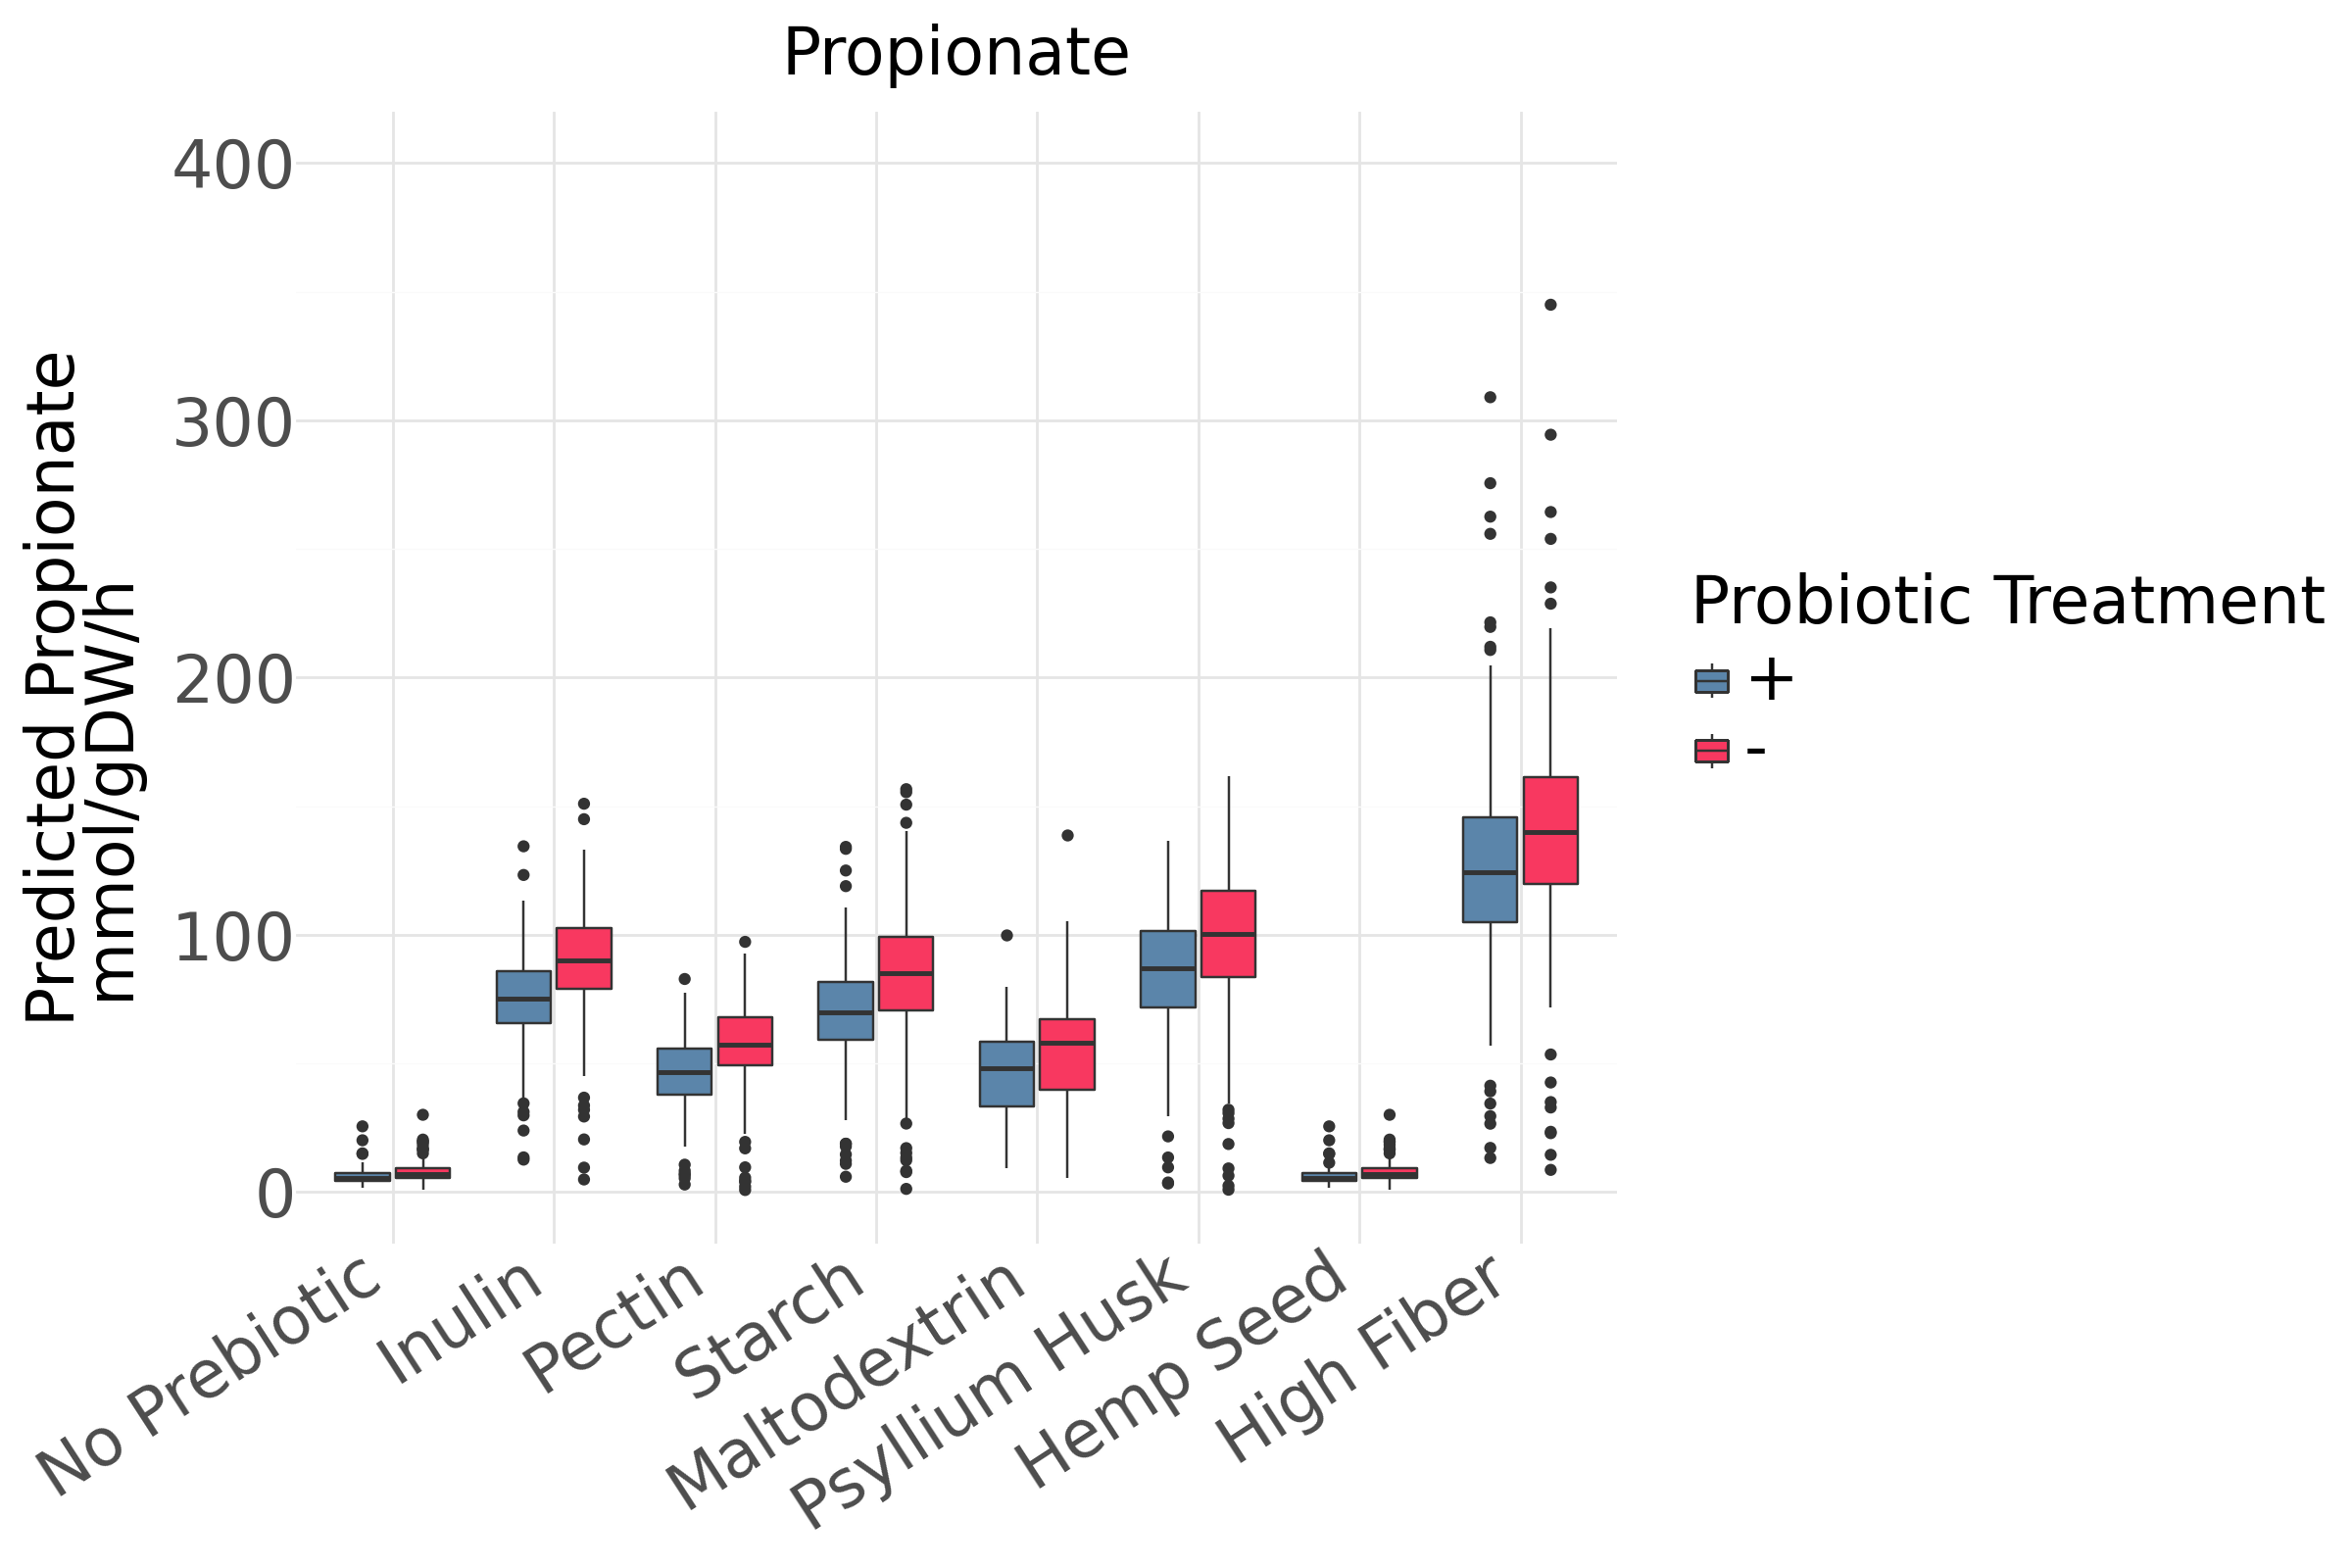

In [70]:
arivale_propionate = (ggplot(production_ppa, aes(x = 'treatment', y = 'flux'))
                    +geom_boxplot(aes(fill = 'probiotic'))
                    +theme_seaborn()
                    +scale_fill_manual(values = {'+': '#5B85AA',
                                                 '-': '#F83860'
                                                })
                    +scale_x_discrete(limits = ['No Prebiotic', 'Inulin','Pectin','Starch','Maltodextrin','Psyllium Husk','Hemp Seed','High Fiber'])
                    +labs(y = 'Predicted Propionate \n mmol/gDW/h', x = '',title = 'Propionate', fill = 'Probiotic Treatment')
                    +theme_minimal()    
                    +ylim(0, 400)
                    +theme(figure_size=(12, 8), text=element_text(size=24),axis_text_x=element_text(rotation=33, hjust=1))
                   )


ggsave(arivale_propionate, '../figures/arivale_propionate.svg', dpi = 300)

arivale_propionate

In [87]:
scipy.stats.mannwhitneyu(production_ppa[(production_ppa['treatment'] == 'No Prebiotic')&(production_ppa['probiotic']== '+')]['flux'],
production_ppa[(production_ppa['treatment'] == 'No Prebiotic')&(production_ppa['probiotic']== '-')]['flux'])

MannwhitneyuResult(statistic=8693.0, pvalue=1.2946886009044433e-05)

In [83]:
production_but = production[production['metabolite'] == 'but[e]'] 
production_ppa = production[production['metabolite'] == 'ppa[e]']

production_but['treatment'] = production_but['treatment']+'_'+production_but['probiotic']
production_ppa['treatment'] = production_ppa['treatment']+'_'+production_ppa['probiotic']

production_but_pvt = pd.pivot_table(production_but, 
                                    columns = 'sample_id',
                                    index = 'treatment', 
                                    values = 'flux')
production_ppa_pvt = pd.pivot_table(production_ppa, 
                                    columns = 'sample_id',
                                    index = 'treatment', 
                                    values = 'flux')

production_but_pvt_noHF = production_but_pvt[~production_but_pvt.index.str.contains('High Fiber')]
production_ppa_pvt_noHF = production_ppa_pvt[~production_ppa_pvt.index.str.contains('High Fiber')]
production_but_pvt

/tmp/ipykernel_2286665/47302511.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_2286665/47302511.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


sample_id,22001612560041,22001612560086,22001612560096,22001612560121,22001612560133,22001612560138,22001612560143,22001612560169,22001612560195,22001612560204,...,22001701510985,22001701511161,22001701511216,22001701511235,22001701511637,22001701511736,22001701511741,22001701511930,22001701511986,22001701512340
treatment,,,,,,,,,,,,,,,,,,,,,
Hemp Seed_+,6.168618,6.068410,2.878135,2.444935,5.333663,3.041500,3.317727,5.083268,4.282397,3.722291,...,4.505700,1.779483,4.789265,3.395615,1.737652,6.086190,9.373162,7.702030,5.958987,2.752331
Hemp Seed_-,5.987098,4.883801,2.301615,2.686456,4.564718,2.220494,2.953830,4.842560,3.283941,2.452897,...,3.787075,0.780402,4.579109,2.639573,1.373530,6.238041,10.386901,8.259167,6.186632,2.808707
High Fiber_+,29.259770,32.179460,25.043274,39.986693,29.744514,27.705638,24.732768,26.167085,23.007536,35.728063,...,36.172006,26.608192,34.372369,27.923648,8.026564,40.866613,29.119880,35.709299,19.291682,28.316701
High Fiber_-,19.603879,18.562371,15.494767,24.464748,15.009918,20.521818,24.748419,18.005696,14.250817,23.163312,...,23.028773,14.488396,24.444832,18.812549,9.859454,32.939857,29.073514,32.973771,12.468956,19.127792
Inulin_+,24.529137,26.415360,23.460425,28.295239,24.095594,27.699028,28.285921,27.934049,27.064743,25.121474,...,36.950315,28.405713,28.898316,29.614333,19.592844,32.422590,36.890613,35.859357,31.207552,30.493224
Inulin_-,18.430461,19.868060,14.756407,18.888172,15.875950,18.324819,22.990904,19.137740,17.226752,19.594519,...,29.360903,18.314618,21.527066,21.570076,9.002357,24.384837,28.834196,25.929850,22.392465,28.918949
Maltodextrin_+,12.512035,37.457525,27.200818,28.305013,12.912027,14.487254,27.771038,27.208261,11.968246,23.188368,...,39.920098,8.749835,27.311906,25.961363,12.607784,30.101108,28.776968,36.090153,28.590108,10.579562
Maltodextrin_-,9.962193,27.504521,22.225377,18.248419,8.844709,9.980882,21.605678,18.112908,8.743448,18.398192,...,31.755808,4.784292,21.944958,18.303600,5.343475,24.671558,22.352937,30.144879,20.082878,8.166950
No Prebiotic_+,6.194538,6.068410,2.878135,2.444935,5.176304,3.041500,3.317727,5.083268,4.282397,3.722291,...,4.505700,1.779483,4.789265,3.395615,1.737652,6.086190,9.373162,7.702030,5.958987,2.752331


In [84]:
optimal_ppa = pd.DataFrame({'Optimal':production_ppa_pvt_noHF.max(),
                            'Standard':production_ppa_pvt.loc['Inulin_+']}).reset_index()

optimal_but = pd.DataFrame({'Optimal':production_but_pvt_noHF.max(),
                            'Standard':production_but_pvt.loc['Inulin_+']}).reset_index()

optimal_ppa_melt = pd.melt(optimal_ppa, 
                id_vars = 'sample_id', 
                value_vars = ['Optimal','Standard'], 
                value_name = 'flux', 
                var_name = 'type')

optimal_but_melt = pd.melt(optimal_but, 
                id_vars = 'sample_id', 
                value_vars = ['Optimal','Standard'], 
                value_name = 'flux', 
                var_name = 'type')
optimal_but_melt

,sample_id,type,flux
0,22001612560041,Optimal,31.957317
1,22001612560086,Optimal,37.457525
2,22001612560096,Optimal,34.021391
3,22001612560121,Optimal,42.308969
4,22001612560133,Optimal,33.626724
...,...,...,...
307,22001701511736,Standard,32.422590
308,22001701511741,Standard,36.890613
309,22001701511930,Standard,35.859357
310,22001701511986,Standard,31.207552


/users/nbohmann/miniconda3/envs/micom-host/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 10 x 5 in image.
/users/nbohmann/miniconda3/envs/micom-host/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: /proj/gibbons/2024_Pendulum_trial/figures/optimal_propionate.svg


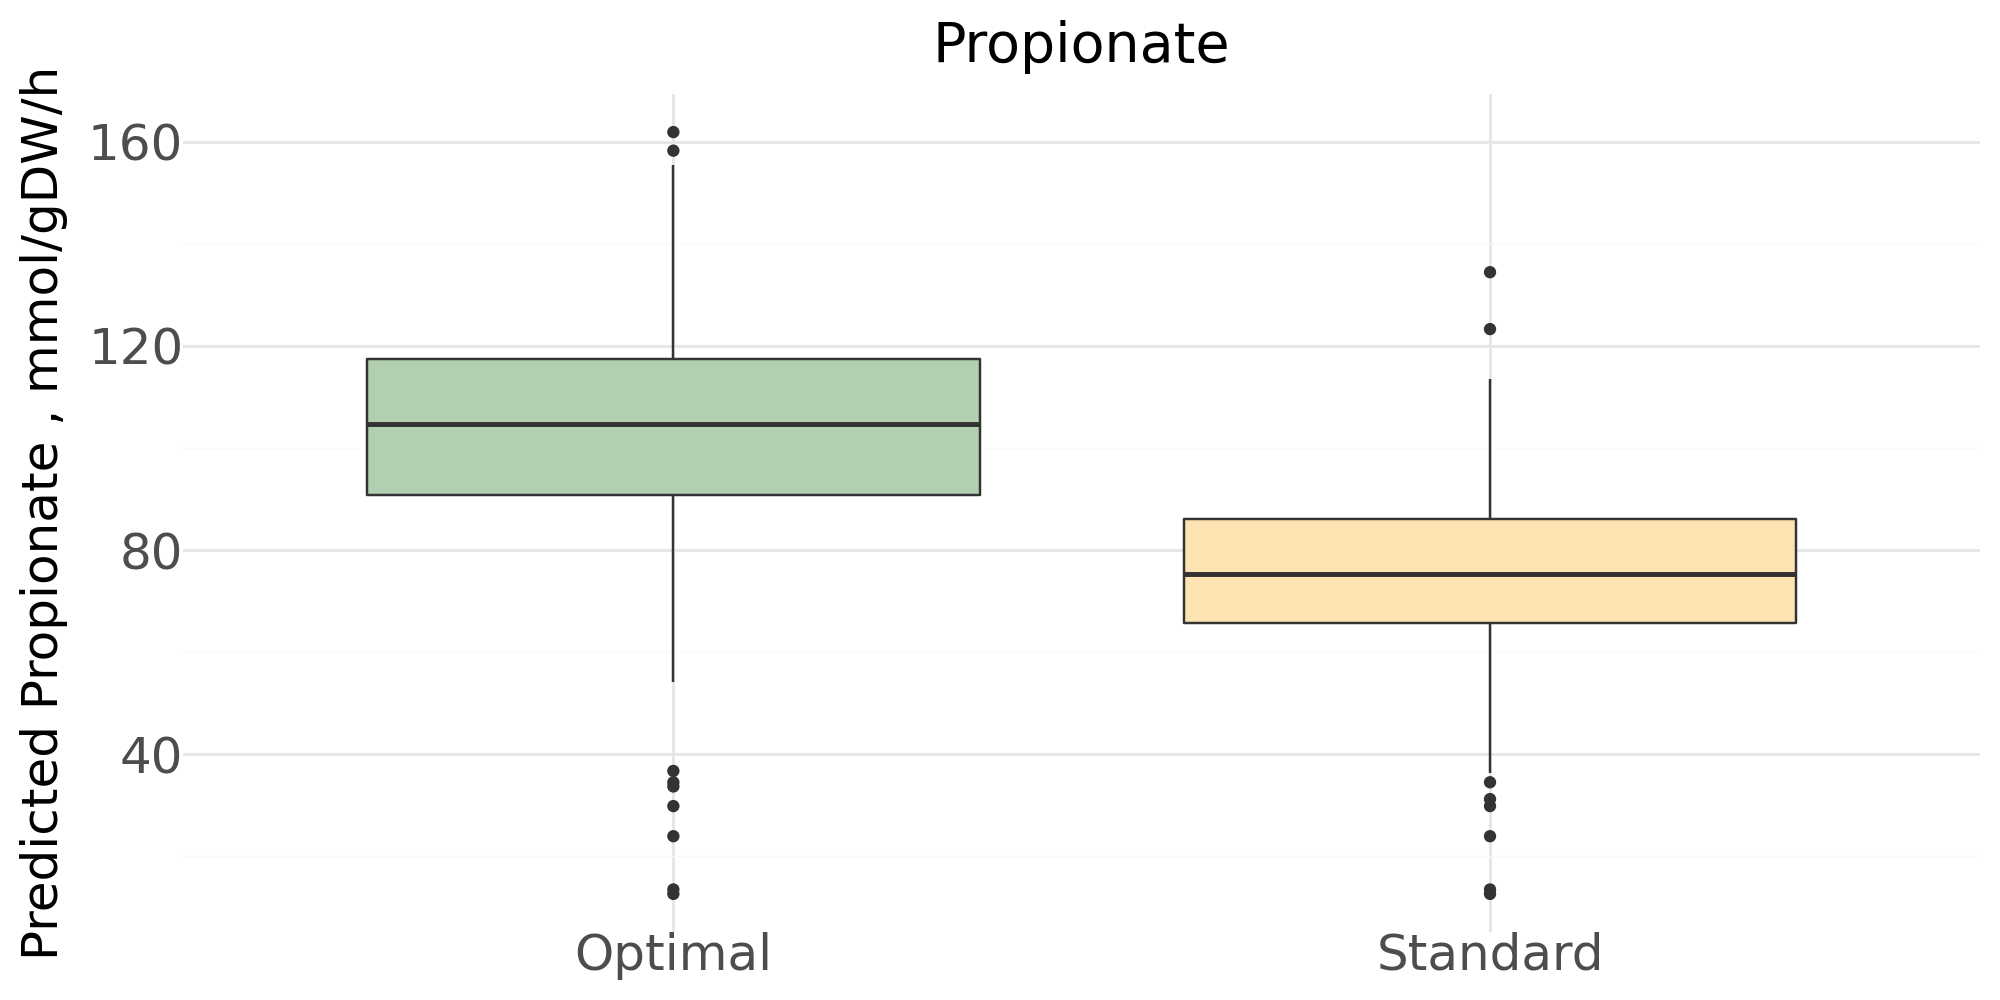

In [96]:
optimal_plot = (ggplot(optimal_ppa_melt, aes(x = 'type', y = 'flux'))
                    +geom_boxplot(aes(fill = 'type'))
                    +scale_fill_manual(values = {'Optimal': '#b2d0b1',
                                                 'Standard': '#fee3b2'
                                                })
                    +labs(y = 'Predicted Propionate , mmol/gDW/h', x = '',title = 'Propionate', fill = 'Probiotic Treatment')
                    +theme_minimal()    
                    +theme(figure_size=(10, 5),
                           legend_position='none',
                           axis_title=element_text(size=18),
                            axis_text=element_text(size=18),
                            plot_title=element_text(size=20)))
                
               
ggsave(optimal_plot, '/proj/gibbons/2024_Pendulum_trial/figures/optimal_propionate.svg',dpi =300)
optimal_plot



/users/nbohmann/miniconda3/envs/micom-host/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 10 x 5 in image.
/users/nbohmann/miniconda3/envs/micom-host/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: /proj/gibbons/2024_Pendulum_trial/figures/optimal_butyrate.svg


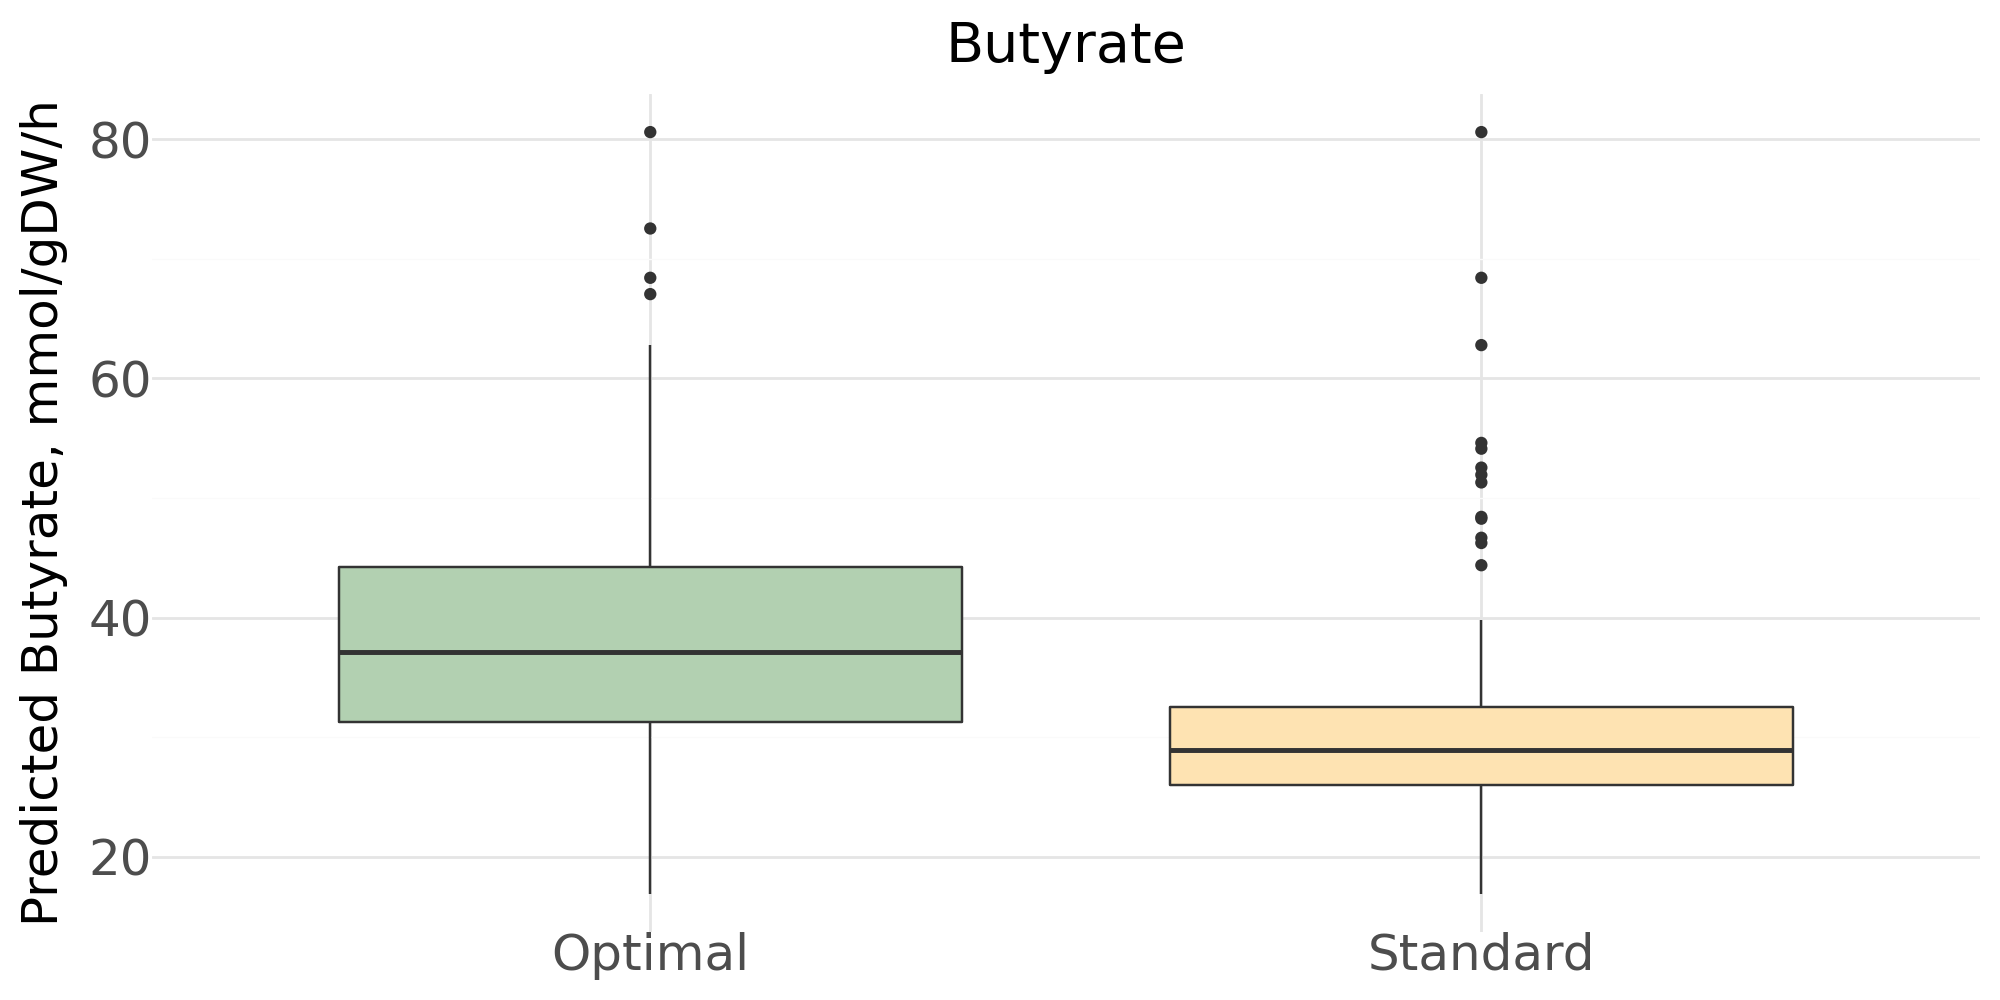

In [97]:
optimal_plot = (ggplot(optimal_but_melt, aes(x = 'type', y = 'flux'))
                    +geom_boxplot(aes(fill = 'type'))
                    +scale_fill_manual(values = {'Optimal': '#b2d0b1',
                                                 'Standard': '#fee3b2'
                                                })
                    +labs(y = 'Predicted Butyrate, mmol/gDW/h', x = '',title = 'Butyrate', fill = 'Probiotic Treatment')
                    +theme_minimal()    
                    +theme(figure_size=(10, 5),
                           legend_position='none',
                           axis_title=element_text(size=18),
        axis_text=element_text(size=18),
        plot_title=element_text(size=20))               )
ggsave(optimal_plot, '/proj/gibbons/2024_Pendulum_trial/figures/optimal_butyrate.svg',dpi =300)
optimal_plot



In [98]:
production_ppa_pvt.index = production_ppa_pvt.index.str.replace('_+', ', Probiotic')
production_ppa_pvt.index = production_ppa_pvt.index.str.replace('_-', ', No Probiotic')
production_ppa_pvt = production_ppa_pvt.T

production_but_pvt.index = production_but_pvt.index.str.replace('_+', ', Probiotic')
production_but_pvt.index = production_but_pvt.index.str.replace('_-', ', No Probiotic')
production_but_pvt = production_but_pvt.T

In [101]:
production_but_pvt_noHF

treatment,"Hemp Seed, Probiotic","Hemp Seed, No Probiotic","Inulin, Probiotic","Inulin, No Probiotic","Maltodextrin, Probiotic","Maltodextrin, No Probiotic","No Prebiotic, Probiotic","No Prebiotic, No Probiotic","Pectin, Probiotic","Pectin, No Probiotic","Psyllium Husk, Probiotic","Psyllium Husk, No Probiotic","Starch, Probiotic","Starch, No Probiotic"
sample_id,,,,,,,,,,,,,,
22001612560041,6.168618,5.987098,24.529137,18.430461,12.512035,9.962193,6.194538,5.979828,22.030797,17.954929,31.670505,27.077038,31.957317,26.561423
22001612560086,6.068410,4.883801,26.415360,19.868060,37.457525,27.504521,6.068410,4.883801,14.636630,8.403193,18.568782,12.079556,36.131617,27.287413
22001612560096,2.878135,2.301615,23.460425,14.756407,27.200818,22.225377,2.878135,2.301615,20.565217,14.342241,34.021391,23.478188,31.943591,22.077637
22001612560121,2.444935,2.686456,28.295239,18.888172,28.305013,18.248419,2.444935,2.686456,42.308969,36.808521,41.182637,31.884179,42.034948,33.949036
22001612560133,5.333663,4.564718,24.095594,15.875950,12.912027,8.844709,5.176304,4.356838,33.626724,31.390219,29.773839,22.164560,29.351645,20.874002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22001701511736,6.086190,6.238041,32.422590,24.384837,30.101108,24.671558,6.086190,6.238041,32.724513,28.652407,43.452698,31.931497,44.234028,35.888421
22001701511741,9.373162,10.386901,36.890613,28.834196,28.776968,22.352937,9.373162,10.386901,37.974758,26.908951,39.127733,33.818138,49.027097,40.742464
22001701511930,7.702030,8.259167,35.859357,25.929850,36.090153,30.144879,7.702030,8.259167,36.761811,32.298649,21.185110,17.569860,49.193079,43.084804


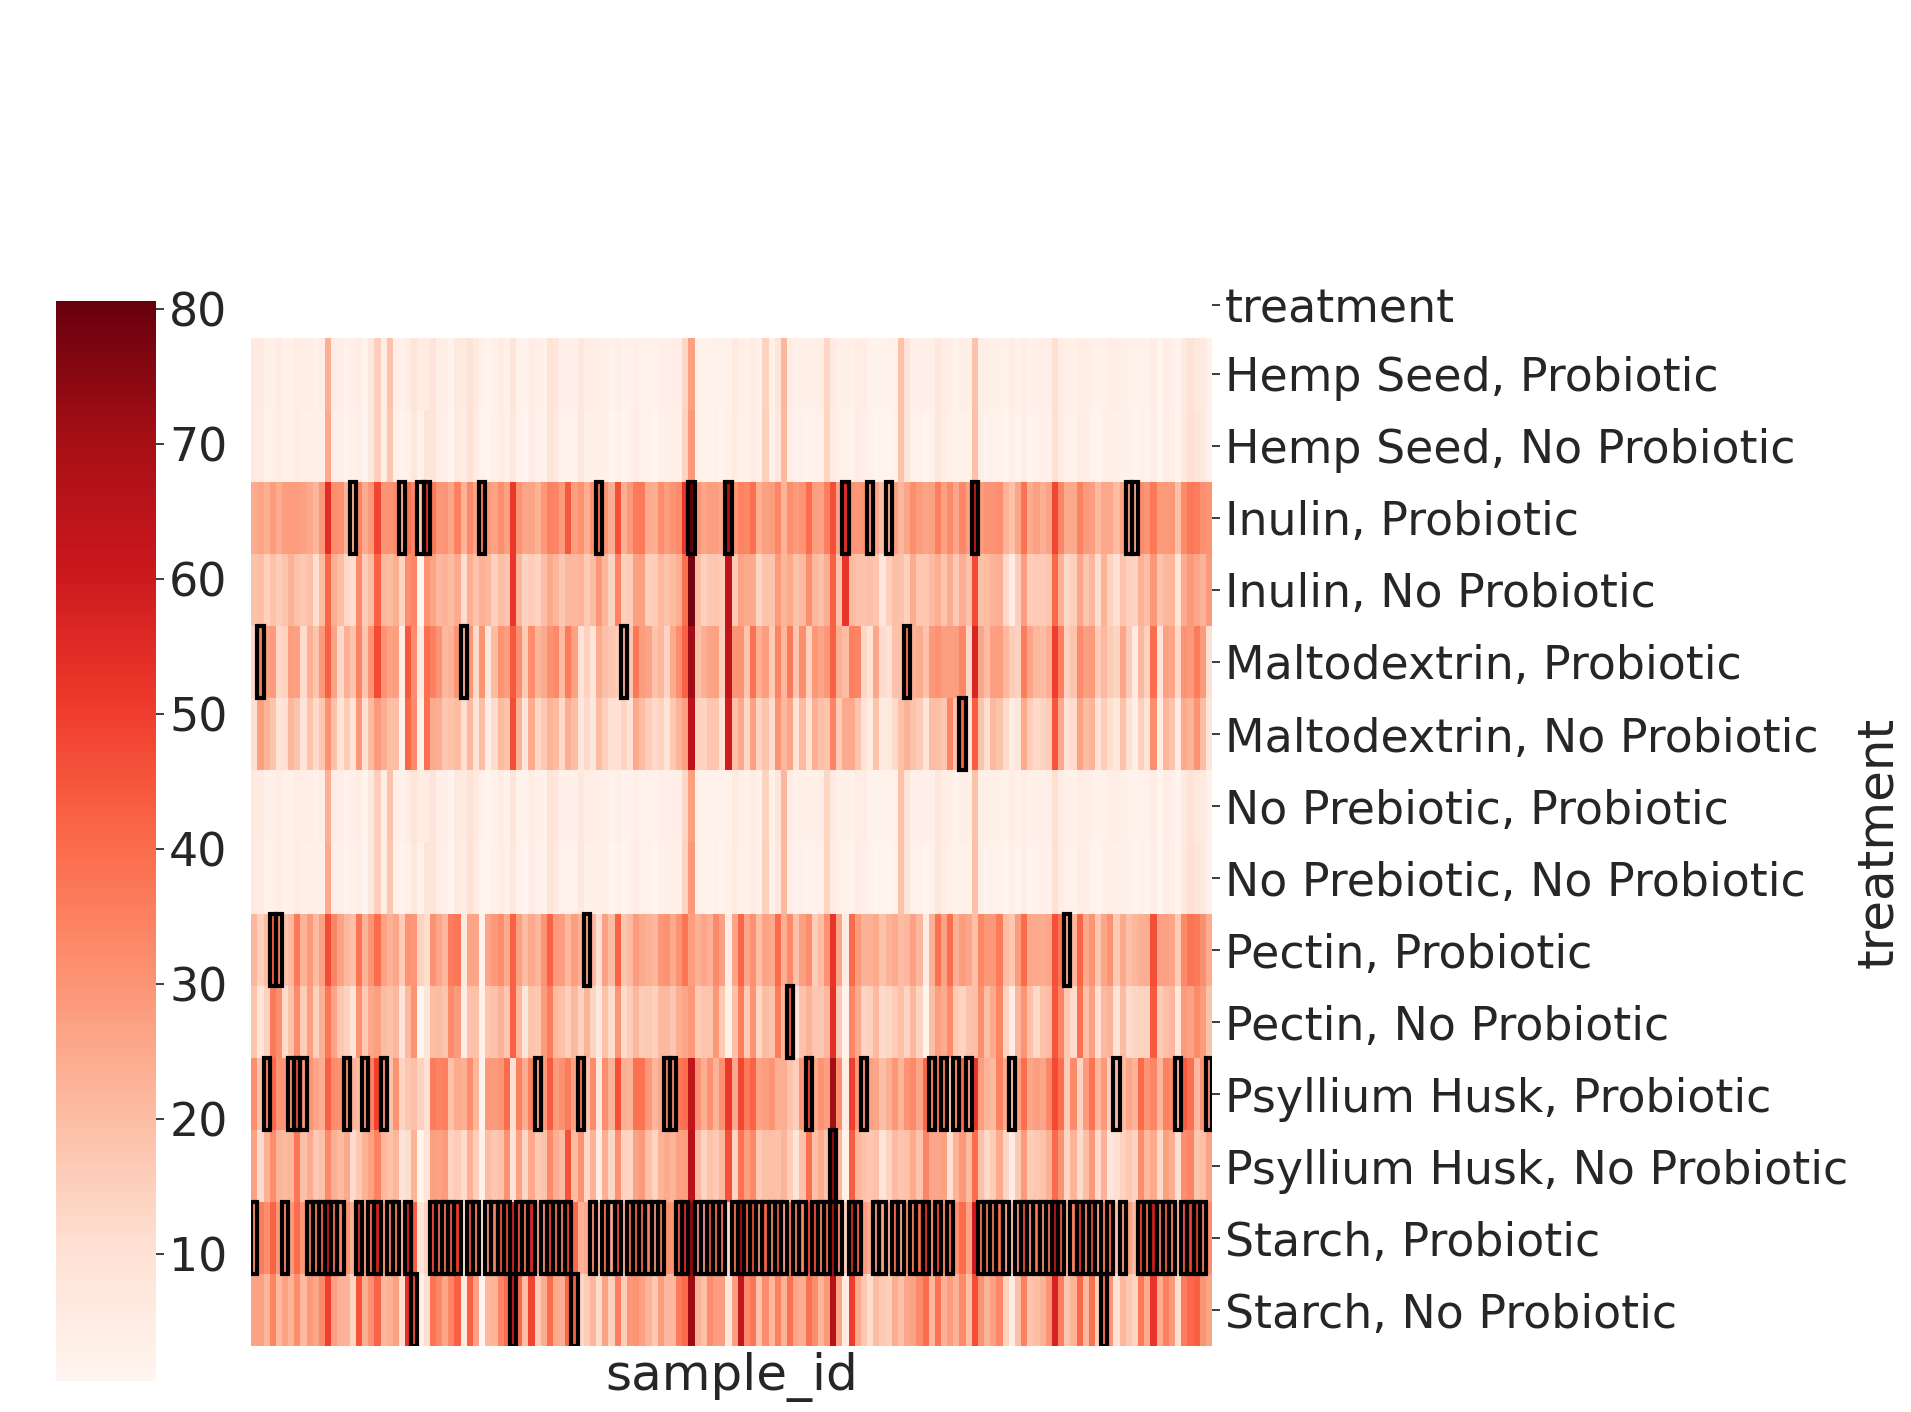

In [99]:
production_but_pvt_noHF = production_but_pvt.drop(columns = ['High Fiber, No Probiotic','High Fiber, Probiotic'])



max_indicies = production_but_pvt_noHF.idxmax(axis = 1)


ax = sns.clustermap(production_but_pvt_noHF.T,
                    cmap = 'Reds',
                    figsize = (20,15),
                    fmt='',
                    xticklabels = False,
                    col_colors = row_colors, 
                    col_cluster = False, 
                    row_cluster = False,
                    cbar_pos= [0.05,0.05,.05,.72],
                    annot_kws={'fontsize': 18, 'color':'white','verticalalignment': 'center'})

for x in (max_indicies.index):
    ax.ax_heatmap.add_patch(Rectangle((production_but_pvt_noHF.index.get_loc(x),
                                      production_but_pvt_noHF.columns.get_loc(max_indicies[x])),
                                       1, 1, fill=False, edgecolor='black', lw=3))


ax.savefig("personalized_but.svg", dpi=300)


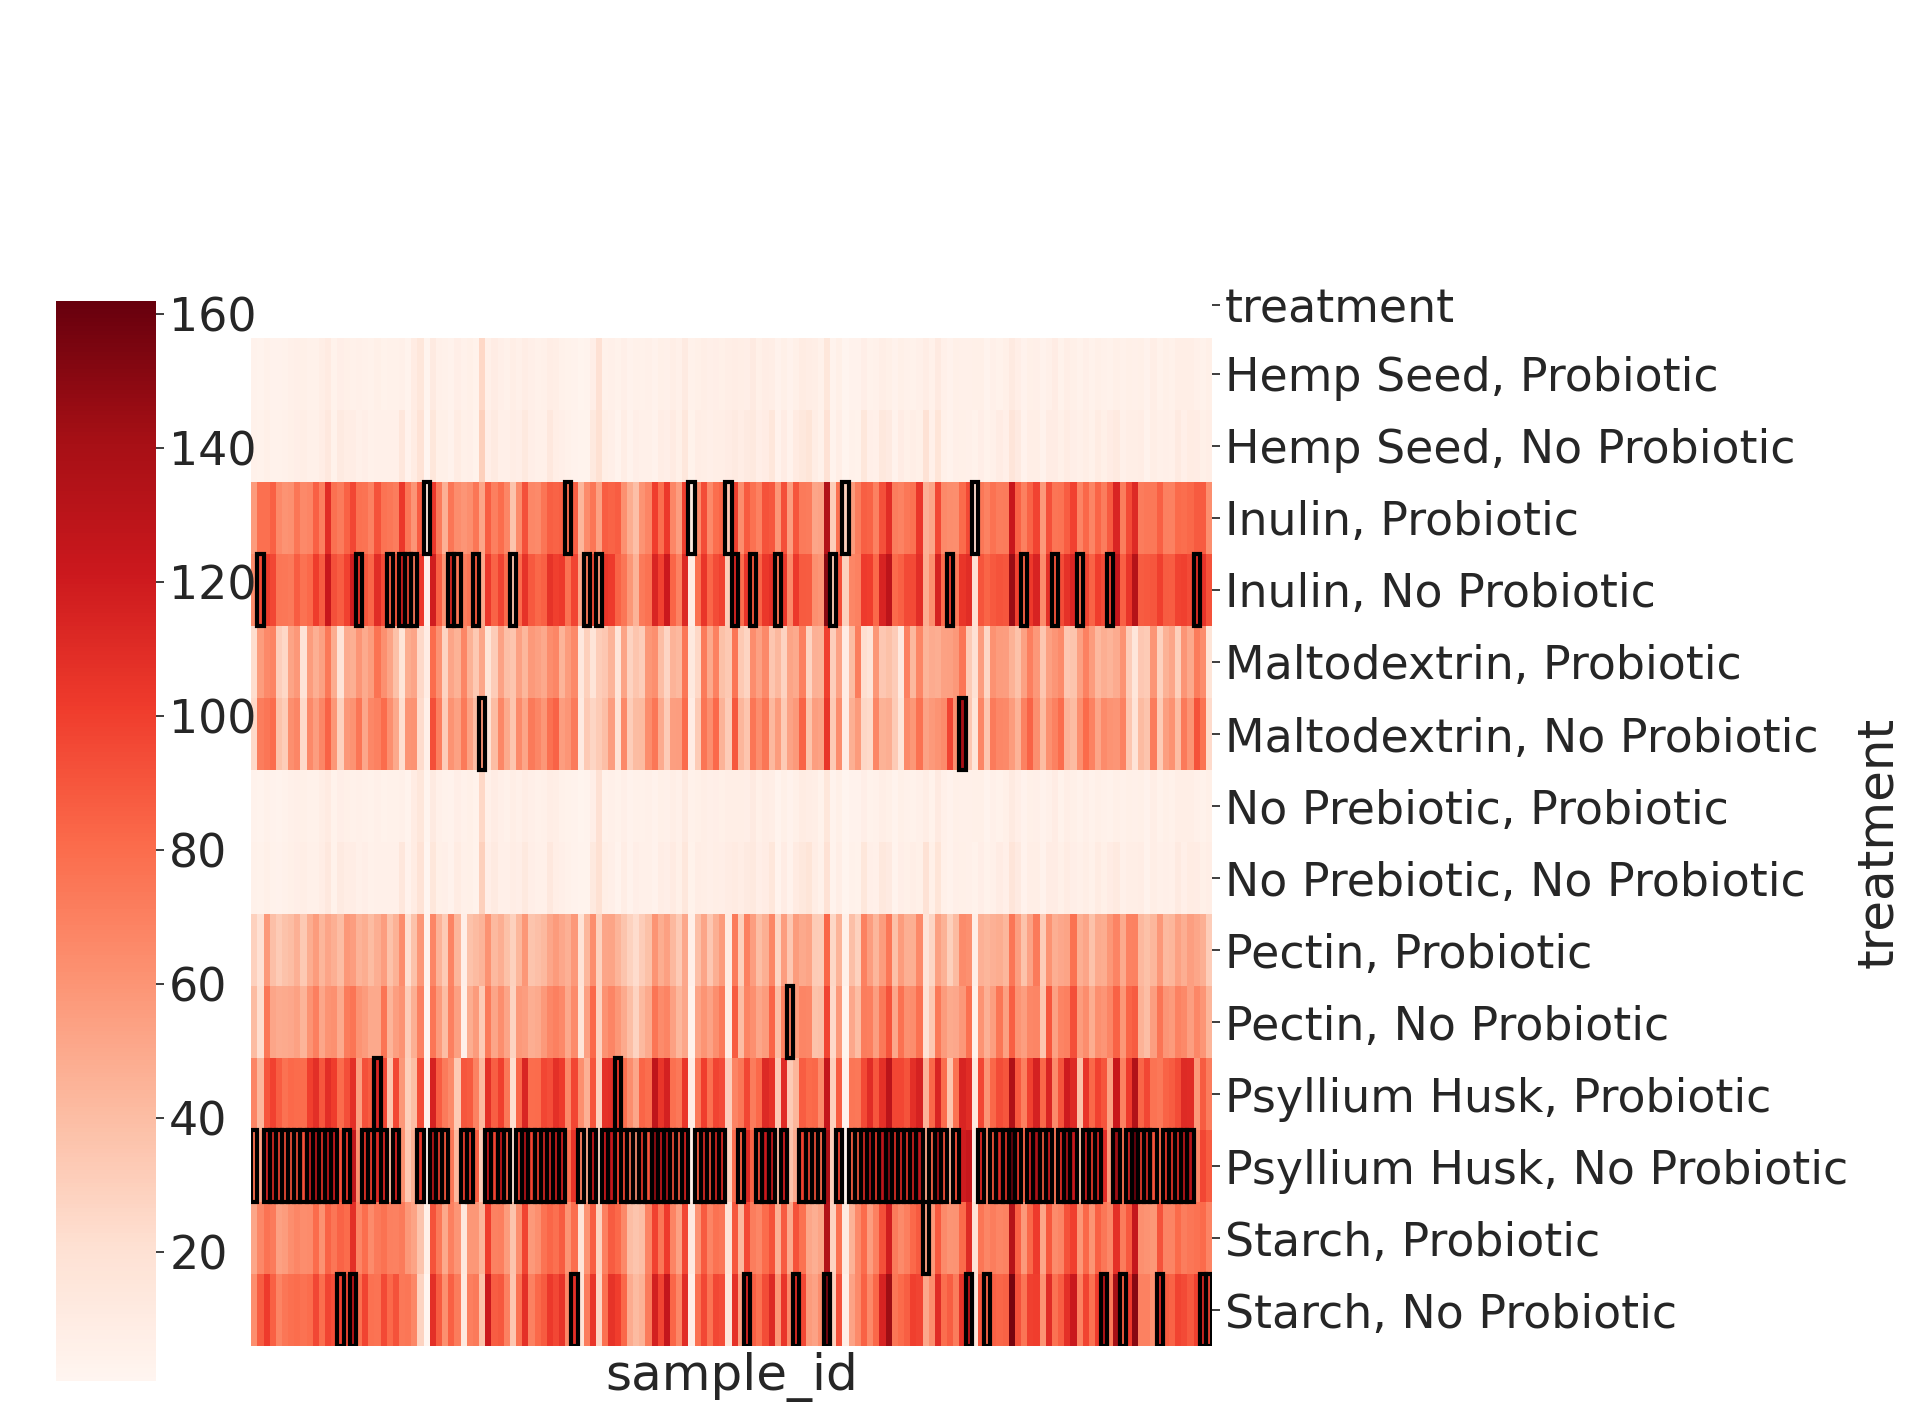

In [100]:
production_ppa_pvt_noHF = production_ppa_pvt.drop(columns = ['High Fiber, No Probiotic','High Fiber, Probiotic'])

max_indicies = production_ppa_pvt_noHF.idxmax(axis = 1)


ax = sns.clustermap(production_ppa_pvt_noHF.T,
                    cmap = 'Reds',
                    figsize = (20,15),
                    fmt='',
                    xticklabels = False,
                    col_colors = row_colors, 
                    col_cluster = False, 
                    row_cluster = False,
                    cbar_pos= [0.05,0.05,.05,.72],
                    annot_kws={'fontsize': 18, 'color':'white','verticalalignment': 'center'})

for x in (max_indicies.index):
    ax.ax_heatmap.add_patch(Rectangle((production_ppa_pvt_noHF.index.get_loc(x),
                                      production_ppa_pvt_noHF.columns.get_loc(max_indicies[x])),
                                       1, 1, fill=False, edgecolor='black', lw=3))

ax.savefig("personalized_ppa.svg", dpi=300)


In [181]:
max_indicies

treatment
Hemp Seed, Probiotic           22001612560785
Hemp Seed, No Probiotic        22001612560785
Inulin, Probiotic              22001612561852
Inulin, No Probiotic           22001612561852
Maltodextrin, Probiotic        22001612561852
Maltodextrin, No Probiotic     22001612562228
No Prebiotic, Probiotic        22001612560785
No Prebiotic, No Probiotic     22001612560785
Pectin, Probiotic              22001612561852
Pectin, No Probiotic           22001612561852
Psyllium Husk, Probiotic       22001612562421
Psyllium Husk, No Probiotic    22001612562421
Starch, Probiotic              22001612561852
Starch, No Probiotic           22001612562421
dtype: object

In [199]:
production_ppa_pvt

treatment,"Hemp Seed, Probiotic","Hemp Seed, No Probiotic","High Fiber, Probiotic","High Fiber, No Probiotic","Inulin, Probiotic","Inulin, No Probiotic","Maltodextrin, Probiotic","Maltodextrin, No Probiotic","No Prebiotic, Probiotic","No Prebiotic, No Probiotic","Pectin, Probiotic","Pectin, No Probiotic","Psyllium Husk, Probiotic","Psyllium Husk, No Probiotic","Starch, Probiotic","Starch, No Probiotic"
sample_id,,,,,,,,,,,,,,,,
22001612560041,3.878953,4.764680,107.347806,123.696113,57.179473,64.559248,22.643535,24.914948,3.941789,4.657443,29.703739,40.874820,67.840778,78.647721,51.417844,63.625603
22001612560086,2.966357,4.539452,103.790357,122.701539,78.791833,95.329616,56.420495,71.876594,2.966357,4.539452,19.799027,22.469428,43.558225,53.381436,66.294700,87.040182
22001612560096,4.766855,6.145610,140.809661,167.155426,78.757462,101.306275,66.241093,75.107157,4.766855,6.145610,57.555063,74.481235,90.161552,113.585771,76.401974,101.895364
22001612560121,3.353537,4.177523,103.136862,118.443155,85.665925,96.370721,68.762572,79.679013,3.353537,4.177523,38.957025,52.061225,98.454040,110.931512,72.986196,85.539806
22001612560133,3.770134,4.118608,101.712695,98.377925,65.945447,75.330708,30.861467,37.182808,3.055600,3.629271,32.550258,48.818847,86.531750,96.742004,54.177931,68.766660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22001701511736,7.757213,6.721415,138.452788,151.149712,78.863873,99.060323,59.369892,73.224838,7.757213,6.721415,47.806038,65.921191,110.518698,126.270831,71.761248,94.674946
22001701511741,7.757450,9.980094,262.590115,264.389015,82.029899,95.074164,49.972520,60.261425,7.757450,9.980094,55.252023,55.250780,109.831752,132.582864,75.657954,88.816590
22001701511930,5.717262,9.503548,115.674915,121.119641,88.212033,109.092447,72.045130,91.485263,5.717262,9.503548,51.377548,66.603483,57.713591,66.146821,77.048705,99.140668
